# Moment that we have all been wating for: KANs

## Universal Approximation Theorem

The **Universal Approximation Theorem** states that a sufficiently large neural network with appropriate activation functions can approximate any continuous function $f$ on a compact domain to arbitrary precision.

### Mathematical Formulation
- Let $f: \mathbb{R}^n \to \mathbb{R}$ be a continuous function.
- For any $\epsilon > 0$, there exists a neural network $\phi$ such that:
  $$
  \|f(x) - \phi(x)\| < \epsilon \quad \forall x \in K
  $$
  where $K \subseteq \mathbb{R}^n$ is a compact set.
- Neural networks with non-polynomial activation functions (e.g., sigmoid, ReLU) and sufficient hidden neurons satisfy this property.

### Cases
- **Arbitrary Width:** A single hidden layer with a sufficient number of neurons.
- **Arbitrary Depth:** A limited number of neurons per layer but sufficient hidden layers.

### Key Features
- **Existence Theorem:** Guarantees the existence of such a neural network but does not provide a method to construct it.
- **Limit Theorem:** Ensures better approximation as the size of the network grows but does not specify the minimal size.


## Kolmogorov–Arnold Representation Theorem

The **Kolmogorov–Arnold Representation Theorem** states that any continuous multivariate function can be represented as a superposition of continuous univariate functions and addition.

### Mathematical Formulation
- Let $f: [0, 1]^n \to \mathbb{R}$ be a continuous function.
- $f$ can be expressed as:
  $$
  f(x_1, \dots, x_n) = \sum_{q=0}^{2n} \Phi_q \left( \sum_{p=1}^n \phi_{q,p}(x_p) \right)
  $$
  where:
  - $\phi_{q,p}: [0, 1] \to \mathbb{R}$ are continuous univariate functions.
  - $\Phi_q: \mathbb{R} \to \mathbb{R}$ are continuous functions.

## Differences Between the Two Theorems

### Scope of Approximation
- The Universal Approximation Theorem focuses on **neural networks** and their ability to approximate functions in specific function spaces.
- The Kolmogorov–Arnold theorem provides a **representation** of any continuous multivariate function using univariate functions and summation.

### Representation vs Approximation
- Universal Approximation is an **approximation theorem**, ensuring closeness to the target function within a margin $\epsilon$.
- Kolmogorov–Arnold is an **exact representation theorem**.

### Practicality
- The Universal Approximation Theorem is widely applied in machine learning.
- Kolmogorov–Arnold is theoretical and has limited practical usage due to the complexity of constructing the representation.

### Input Functions
- Universal Approximation uses activation functions like sigmoid or ReLU.
- Kolmogorov–Arnold uses general continuous univariate functions $\phi_{q,p}$ and summations.

## Implementation Details

### 1. Residual Activation Functions
We include a **basis function** $b(x)$, similar to residual connections, such that the activation function $\phi(x)$ is expressed as the sum of the basis function $b(x)$ and a spline function:
$$
\phi(x) = w_b b(x) + w_s \text{spline}(x). \tag{2.10}
$$

- **Basis Function**: For most cases, $b(x)$ is set to the SiLU activation function, defined as:
  $$
  b(x) = \text{silu}(x) = \frac{x}{1 + e^{-x}}. \tag{2.11}
  $$

- **Spline Function**: The spline function $\text{spline}(x)$ is parameterized as a linear combination of B-splines:
  $$
  \text{spline}(x) = \sum_i c_i B_i(x). \tag{2.12}
  $$
  Here:
  - $c_i$ are trainable parameters.
  - $B_i(x)$ are the basis splines (B-splines).

**Explanation**:
- The weights $w_b$ and $w_s$ are theoretically redundant because their effects could be absorbed into the definitions of $b(x)$ and $\text{spline}(x)$. However, these weights are included as trainable factors to better control the overall magnitude of the activation function.
- This modular design ensures flexibility in combining the residual connection (via $b(x)$) with the learnable spline representation.


### 2. Initialization Scales
Each activation function is initialized with specific scales to ensure stability during training:
- The weight $w_s$ is initialized to $1$, and the spline function $\text{spline}(x)$ is initialized to be close to $0^2$.
- The weight $w_b$ is initialized using **Xavier initialization**, which is commonly used for linear layers in MLPs.

**Explanation**:
- Xavier initialization ensures that the weights are neither too large nor too small, avoiding issues like vanishing or exploding gradients.

### 3. Update of Spline Grids
The spline grid is updated dynamically during training based on the input activations. This is crucial because splines are typically defined on bounded regions, but activation values can evolve outside of these regions during training.

**Explanation**:
- By adapting the spline grid on the fly, the method ensures that the spline function remains effective even as the data distribution changes during the optimization process.

## Example of KAN with two inputs

$$
f(\mathbf{x}) = \sum_{q=1}^{2n+1} \Phi_q \left( \sum_{p=1}^{n} \varphi_{q,p}(x_p) \right)
$$

$$
n = 2
$$

$$
2n + 1 = 5
$$

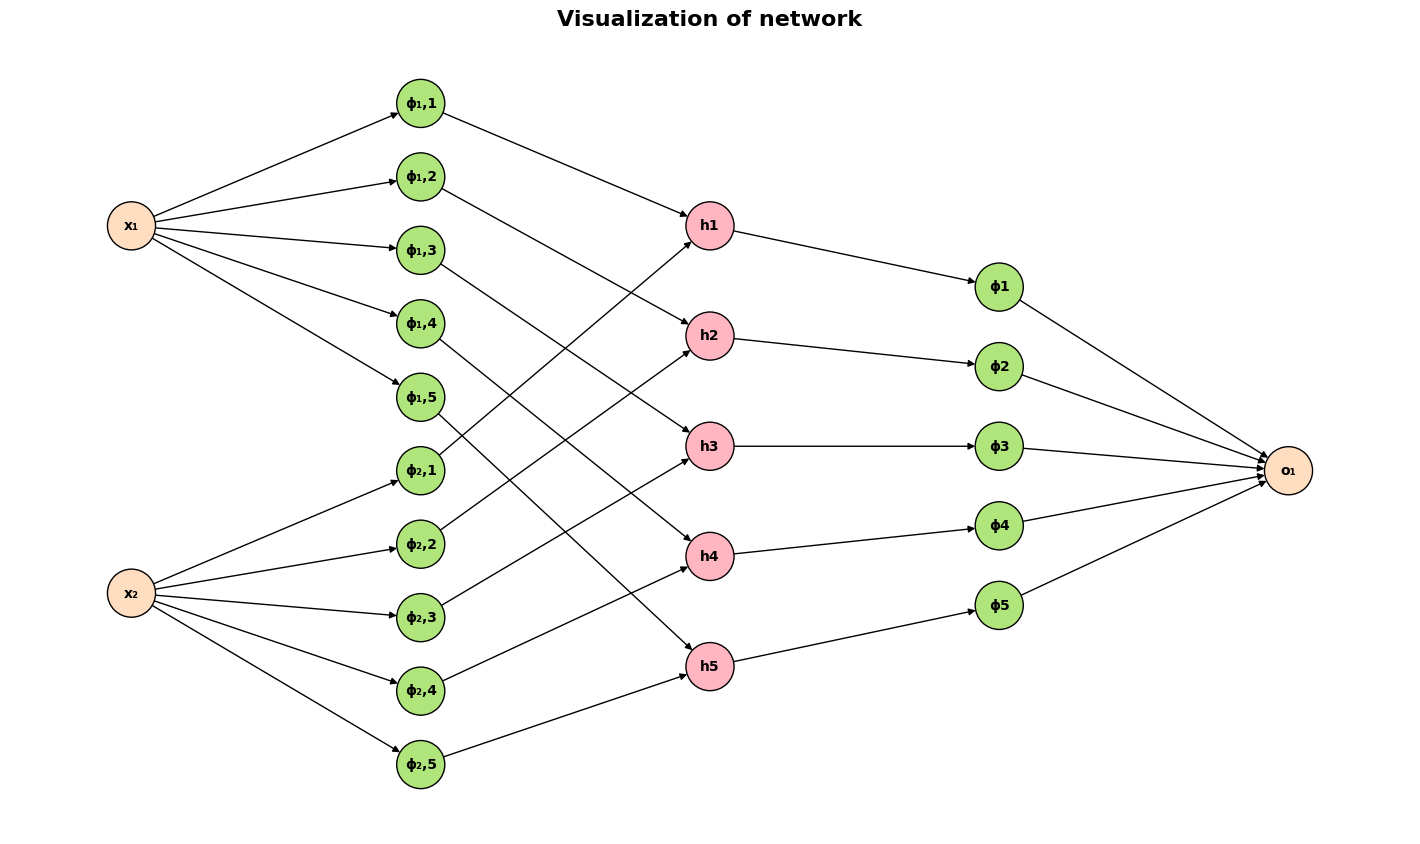

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

inputs = ['x₁', 'x₂']
first_layer_row1 = [f'ϕ₁,{i}' for i in range(1, 6)]  # First row (ϕ₁,1 to ϕ₁,5)
first_layer_row2 = [f'ϕ₂,{i}' for i in range(1, 6)]  # Second row (ϕ₂,1 to ϕ₂,5)
hidden_layer = [f'h{i}' for i in range(1, 6)]
second_layer = [f'ϕ{i}' for i in range(1, 6)]
output = ['o₁']

# Add edges
for node in first_layer_row1:
    G.add_edge('x₁', node)
for node in first_layer_row2:
    G.add_edge('x₂', node)

# First layer to hidden layer
for i, hidden in enumerate(hidden_layer, 1):
    G.add_edge(f'ϕ₁,{i}', hidden)
    G.add_edge(f'ϕ₂,{i}', hidden)

# Hidden layer to second layer
for i, hidden in enumerate(hidden_layer, 1):
    G.add_edge(hidden, f'ϕ{i}')

# Second layer to output
for node in second_layer:
    G.add_edge(node, output[0])

# Adjust positions
pos = {}
pos['x₁'] = (0, 3)  
pos['x₂'] = (0, 0) 

for i, node in enumerate(first_layer_row1):
    pos[node] = (1, 4 - i * 0.6)  
for i, node in enumerate(first_layer_row2):
    pos[node] = (1, 1 - i * 0.6)  
for i, node in enumerate(hidden_layer):
    pos[node] = (2, 3 - i * 0.9)  

for i, node in enumerate(second_layer):
    pos[node] = (3, 2.5 - i * 0.65)  

pos['o₁'] = (4, 1) 

plt.figure(figsize=(14, 8))
nx.draw(
    G, pos,
    node_color=["#FFDDC1" if n in inputs or n in output else "#B0E57C" if "ϕ" in n else "#FFB6C1" for n in G.nodes],
    node_size=1200,
    font_size=10,
    font_weight="bold",
    with_labels=True,
    arrows=True,
    edgecolors="black"
)

plt.title("Visualization of network", fontsize=16, fontweight="bold")
plt.axis('off') 
plt.show()


Let us firstly rewrite the function fitting to pyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
def basis_function(i, p, t, x):
    if p == 0:  # Base case: degree 0
        return torch.where((t[i] <= x) & (x < t[i + 1]), 1.0, 0.0)
    else:
        # Recursive definition with torch operations
        left_num = x - t[i]
        left_den = t[i + p] - t[i]
        left = (left_num / left_den) * basis_function(i, p - 1, t, x) if left_den != 0 else 0.0

        right_num = t[i + p + 1] - x
        right_den = t[i + p + 1] - t[i + 1]
        right = (right_num / right_den) * basis_function(i + 1, p - 1, t, x) if right_den != 0 else 0.0

        return left + right

Knot vector: [-1.         -1.         -1.         -1.         -0.84615385 -0.69230769
 -0.53846154 -0.38461538 -0.23076923 -0.07692308  0.07692308  0.23076923
  0.38461538  0.53846154  0.69230769  0.84615385  1.          1.
  1.          1.        ]
Coefficients: tensor([[-0.4824],
        [-0.4936],
        [-0.4764],
        [-0.5865],
        [-0.2899],
        [-0.8929],
        [ 0.0825],
        [-1.1825],
        [ 0.1041],
        [-0.8255],
        [ 1.1610],
        [ 0.2273],
        [ 0.4821],
        [ 0.8157]])


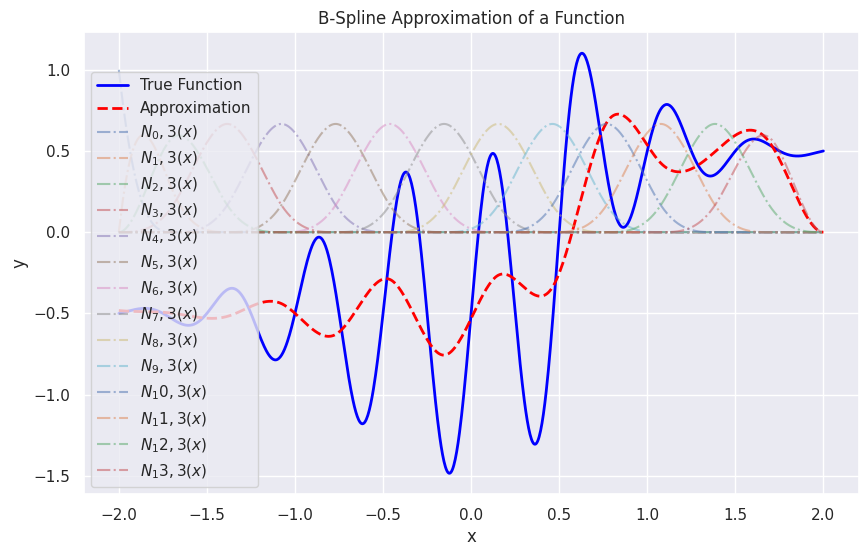

In [5]:
n_control_points = 14
k = 3
t = np.linspace(-1, 1, num=n_control_points)
t = np.pad(t, (k, k), mode='edge')
t_values = np.linspace(t[0], t[-1], 1000)

x_values = torch.linspace(-2, 2, 1000)
t_tensor = torch.tensor(t, dtype=torch.float32)
t_values_tensor = torch.tensor(t_values, dtype=torch.float32)

print("Knot vector:", t)

# Precompute basis functions
bfs = torch.zeros((len(t_values), n_control_points), dtype=torch.float32)
for i in range(n_control_points):
    bfs[:, i] = basis_function(i, k, t_tensor, t_values_tensor)

# Function to approximate
fn = lambda x: (
    torch.sin(4 * np.pi * x_values) * torch.exp(-x_values**2)  # Oscillatory and decaying
    + 0.5 * torch.tanh(10 * x_values - 5)  # Sharp transition
)
fn_values = fn(x_values)


# Solve for coefficients using lstsq
coeffs = torch.linalg.lstsq(bfs, fn_values.unsqueeze(1))
coeffs = coeffs.solution
print("Coefficients:", coeffs)

# Compute predicted values
y_pred = torch.matmul(bfs, coeffs)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), fn_values.numpy(), label="True Function", color='blue', linewidth=2)
plt.plot(x_values.numpy(), y_pred.numpy(), label="Approximation", color='red', linewidth=2, linestyle='--')
for i in range(bfs.shape[1]):
    plt.plot(x_values.numpy(), bfs[:, i].numpy(), label=f'$N_{i},{k}(x)$', linestyle='-.', alpha=0.5)
plt.title("B-Spline Approximation of a Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [91]:
x_values = torch.linspace(-2, 2, steps=1000)
fn = lambda x: torch.sin(-2 * np.pi * x)
fn = lambda x: (
    torch.sin(4 * np.pi * x_values) * torch.exp(-x_values**2)  # Oscillatory and decaying
    + 0.5 * torch.tanh(10 * x_values - 5)  # Sharp transition
)
fn_values = fn(x_values)

In [92]:
def basis_function(i, p, t, x):
    if p == 0:
        # Degree 0
        return torch.where((t[i] <= x) & (x < t[i + 1]), torch.ones_like(x), torch.zeros_like(x))
    else:
        # Recursive definition
        left_num = x - t[i]
        left_den = t[i + p] - t[i]
        left = (left_num / left_den) * basis_function(i, p - 1, t, x) if left_den != 0 else torch.zeros_like(x)
        
        right_num = t[i + p + 1] - x
        right_den = t[i + p + 1] - t[i + 1]
        right = (right_num / right_den) * basis_function(i + 1, p - 1, t, x) if right_den != 0 else torch.zeros_like(x)
        
        return left + right

In [6]:
class BSplineLayer(nn.Module):
    def __init__(self, degree, n_control_points):
        super(BSplineLayer, self).__init__()
        self.degree = degree
        self.n_control_points = n_control_points
        self.num_basis = n_control_points
        self.weights = nn.Parameter(torch.randn(self.num_basis))  # Trainable weights
        self.scale = nn.Parameter(torch.tensor(1.0)) # Trainable scaling factor
        self.shift = nn.Parameter(torch.tensor(0.0)) # Trainable shift factor
        self.prepare_knots()

    def prepare_knots(self):
        knot_vector = np.linspace(-2, 2, num=self.n_control_points) 
        knot_vector = np.pad(knot_vector, (self.degree, self.degree), mode='edge')
        self.knot_vector = torch.tensor(knot_vector, dtype=torch.float32)
        self.knot_vector.requires_grad = False

    def eval_bases(self, x):
        N = []
        for i in range(self.num_basis):
            N_i = basis_function(i, self.degree, self.knot_vector, x)
            N.append(N_i)
        self.N = torch.stack(N, dim=1)


    def forward(self, x):
        # Compute basis functions
        self.prepare_bases(x)
        output = self.N @ self.weights 
        output = output * self.scale + self.shift
        return output
    

class BSplineNet(nn.Module):
    def __init__(self, n_layers):
        super(BSplineNet, self).__init__()
        self.layers = nn.ModuleList([BSplineLayer(degree=3, n_control_points=14) for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

Epoch [100/1000], Loss: 0.255689
Epoch [200/1000], Loss: 0.200718
Epoch [300/1000], Loss: 0.187194
Epoch [400/1000], Loss: 0.180295
Epoch [500/1000], Loss: 0.175591
Epoch [600/1000], Loss: 0.172004
Epoch [700/1000], Loss: 0.169223
Epoch [800/1000], Loss: 0.167142
Epoch [900/1000], Loss: 0.165702
Epoch [1000/1000], Loss: 0.164810


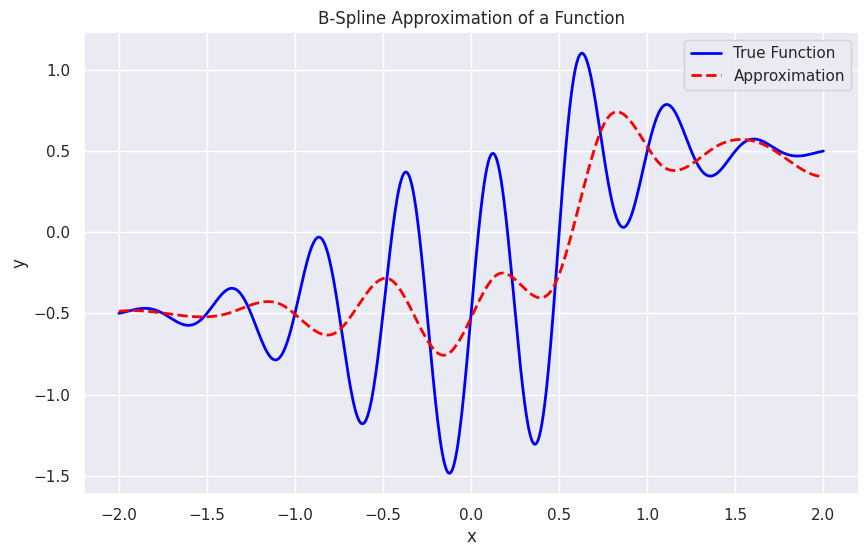

In [7]:
model = BSplineNet(n_layers=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_values)
    loss = criterion(outputs, fn_values)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
k# Compute predicted values
y_pred = model(x_values).detach()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), fn_values.numpy(), label="True Function", color='blue', linewidth=2)
plt.plot(x_values.numpy(), y_pred.numpy(), label="Approximation", color='red', linewidth=2, linestyle='--')
plt.title("B-Spline Approximation of a Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()